In [37]:
# data and numbers
import os
import numpy as np
import pandas as pd
import datetime as dt
import time
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import pyarrow as pa, pyarrow.parquet as pq
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import folium
from folium.plugins import HeatMap, MarkerCluster
from tqdm import tqdm



In [2]:
# Load the data file
df = pd.read_parquet('data/meters/combinedmeters/meter_with_temp.parquet')

In [3]:
df.head()

,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature
0,2016-01-01 00:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 05:00:00,19.4
1,2016-01-01 01:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 06:00:00,21.1
2,2016-01-01 02:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 07:00:00,21.1
3,2016-01-01 03:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 08:00:00,20.6
4,2016-01-01 04:00:00,Panther_parking_Lorriane,0.0,US/Eastern,Panther,Parking,36012.7,2016-01-01 09:00:00,21.1


Function to find and remove all zero gaps - zero readings longer than 24 continous hours will be replaced by NaN

In [4]:
def find_zero_gaps(df, thresh=0.0, long_gap_hrs=24):
    """Returns (gap_summary, long_gap_mask)

    gap_summary – one row per contiguous zero block
    long_gap_mask – boolean Series aligned with df.index, True for long gaps
    """
    # -------- vectorised gap detection ---------
    df = df.sort_values(["building_id", "timestamp_local"])
    is_gap = df["meter_reading"].le(thresh)
    change = (
        is_gap.ne(is_gap.shift(fill_value=False)) |
        df["building_id"].ne(df["building_id"].shift(fill_value=df["building_id"].iloc[0]))
    )
    grp_id = change.cumsum()

    summary = (
        df[is_gap]
          .groupby(["building_id", grp_id], sort=False)
          .agg(ts_from=("timestamp_local", "first"),
               ts_to  =("timestamp_local", "last"),
               cnt    =("timestamp_local", "size"))
          .reset_index(level=1, drop=True)
          .rename(columns={"cnt": "duration_hours"})
          .reset_index()
    )

    run_len = is_gap.groupby(grp_id).transform("size").where(is_gap, 0)
    long_gap_mask = is_gap & (run_len >= long_gap_hrs)

    return summary, long_gap_mask


In [5]:
gap_df, long_gap_mask = find_zero_gaps(
    df[["timestamp_local","building_id","meter_reading"]].copy(),
    thresh=0.0,
    long_gap_hrs=24
)

print(gap_df["duration_hours"].describe())
print(f"Long‑gap hours flagged: {long_gap_mask.sum():,}")

nan_before = df["meter_reading"].isna().sum()
df.loc[long_gap_mask, "meter_reading"] = np.nan
nan_after = df["meter_reading"].isna().sum()

print(f"NaNs BEFORE masking : {nan_before:,}")
print(f"NaNs AFTER  masking : {nan_after:,}")


count    36712.000000
mean        31.590706
std        358.150539
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      17544.000000
Name: duration_hours, dtype: float64
Long‑gap hours flagged: 1,024,246
NaNs BEFORE masking : 1,312,095
NaNs AFTER  masking : 2,336,341


In [6]:
df.head()

,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature
0,2016-01-01 00:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 05:00:00,19.4
1,2016-01-01 01:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 06:00:00,21.1
2,2016-01-01 02:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 07:00:00,21.1
3,2016-01-01 03:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 08:00:00,20.6
4,2016-01-01 04:00:00,Panther_parking_Lorriane,NaN,US/Eastern,Panther,Parking,36012.7,2016-01-01 09:00:00,21.1


In [7]:
# Print a summary using info() (shows non-null count per column)
print("DataFrame info:")
print(df.info())

# Count the number of missing (NaN) values per column
nan_counts = df.isnull().sum()
print("\nMissing values per column:")
print(nan_counts)

# Calculate the percentage of missing values per column
nan_percent = df.isnull().mean() * 100
print("\nPercentage of missing values per column:")
print(nan_percent)


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27684432 entries, 0 to 27684431
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   timestamp_local    datetime64[ns]
 1   building_id        object        
 2   meter_reading      float64       
 3   timezone           object        
 4   site_id            object        
 5   primaryspaceusage  object        
 6   sqm                float64       
 7   timestamp_utc      datetime64[ns]
 8   airTemperature     float64       
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 1.9+ GB
None

Missing values per column:
timestamp_local            0
building_id                0
meter_reading        2336341
timezone                   0
site_id                    0
primaryspaceusage     333336
sqm                        0
timestamp_utc           3156
airTemperature        104412
dtype: int64

Percentage of missing values per column:
timestamp_local      

Data Interpolation

In [8]:
def interpolate_gaps_efficient(df, max_gap_hours=24):
    """
    Fill short gaps (<= max_gap_hours) in each building's series.
    Only interior NaNs are interpolated; leading / trailing NaNs remain NaN.
    """
    df = df.copy()
    df['timestamp_local'] = pd.to_datetime(df['timestamp_local'])
    df = df.sort_values(['building_id', 'timestamp_local'])

    df['meter_reading'] = (
        df.groupby('building_id')['meter_reading']
          .transform(lambda s: s.interpolate(
              method='linear',
              limit=max_gap_hours,
              limit_direction='both',
              limit_area='inside'      # avoid edge extrapolation
          ))
    )
    return df


In [9]:
def benchmark_interpolation(df):
    start = time.time()
    df_interp = interpolate_gaps_efficient(df, max_gap_hours=24)
    secs = time.time() - start

    before = df['meter_reading'].isna().sum()
    after  = df_interp['meter_reading'].isna().sum()

    print(f"Interpolation finished in {secs:.2f}s")
    print(f"NaNs before : {before:,}")
    print(f"NaNs after  : {after:,}  (↓ {before-after:,})")

    return df_interp

df_interpolated = benchmark_interpolation(df)


Interpolation finished in 15.24s
NaNs before : 2,336,341
NaNs after  : 2,121,695  (↓ 214,646)


In [10]:
def gap_length_distribution(df_interpolated):
    is_nan = df_interpolated['meter_reading'].isna()
    change = is_nan.ne(is_nan.shift()) | df_interpolated['building_id'].ne(df_interpolated['building_id'].shift())
    grp_id = change.cumsum()
    lengths = is_nan.groupby(grp_id).sum().loc[lambda x: x > 0]
    return lengths.value_counts().sort_index()

print(gap_length_distribution(df_interpolated).head(20))


meter_reading
1     18
2     19
3     28
4     12
5     16
6     10
7     16
8      9
9      9
10    10
11    14
12     6
13    11
14     5
15    14
16     5
17     8
18     4
19    11
20     3
Name: count, dtype: int64


In [11]:
# already built earlier
gap_len = gap_length_distribution(df_interpolated)      # Series: {run_length: count}

cum_rows  = (gap_len.index * gap_len).cumsum()
total_nan = cum_rows.iloc[-1]

coverage = (cum_rows / total_nan).rename("covered_%")
print(
    pd.DataFrame({"rows_upto_len": cum_rows, "covered_%": (coverage*100).round(1)})
          .head(10)
)


               rows_upto_len  covered_%
meter_reading                          
1                         18        0.0
2                         56        0.0
3                        140        0.0
4                        188        0.0
5                        268        0.0
6                        328        0.0
7                        440        0.0
8                        512        0.0
9                        593        0.0
10                       693        0.0


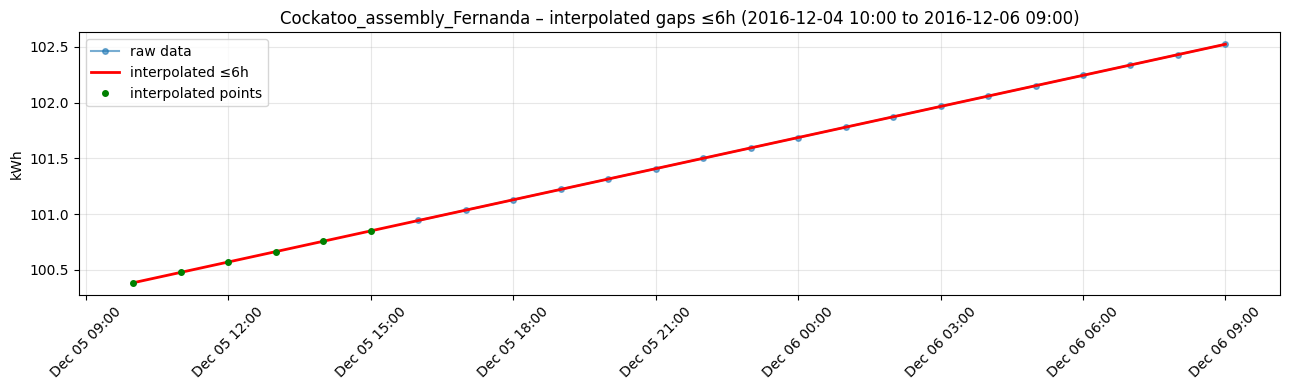

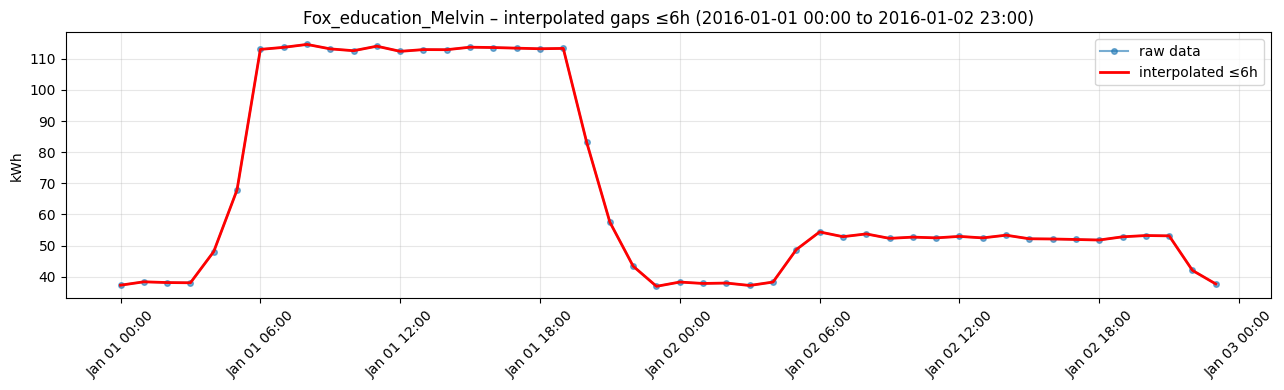

In [12]:
def plot_before_after(building_id, max_gap, days_to_show=2):
    """
    Plot the meter readings for a building, showing the raw data and interpolated data.
    
    Parameters:
    -----------
    building_id : str
        The ID of the building to plot
    max_gap : int
        Maximum gap hours to interpolate
    days_to_show : int, default=2
        Number of days to show in the plot
    """
    # Get data for the selected building
    sub = df_interpolated[df_interpolated['building_id'] == building_id].copy()
    filled = interpolate_gaps_efficient(sub, max_gap_hours=max_gap)
    
    # Find gaps by comparing raw and filled data
    has_gaps = sub['meter_reading'].isna() & filled['meter_reading'].notna()
    
    # If no gaps found, find a random region
    if has_gaps.sum() == 0:
        sample_slice = slice(0, min(48, len(sub)))
    else:
        # Find a window centered on gaps
        gap_indices = np.where(has_gaps)[0]
        mid_gap = gap_indices[len(gap_indices)//2]
        start_idx = max(0, mid_gap - 24)
        sample_slice = slice(start_idx, start_idx + 48)  # ~2 days window
    
    # Sort data by timestamp
    sub = sub.sort_values('timestamp_local')
    filled = filled.sort_values('timestamp_local')
    
    # Use the sample slice or time window
    if len(sub) > 48:  # If we have enough data
        if 'sample_slice' in locals():
            sub = sub.iloc[sample_slice]
            filled = filled.iloc[sample_slice]
        else:
            # Limit to the specified days
            hours_to_show = 24 * days_to_show
            start_date = sub['timestamp_local'].iloc[0]
            end_date = start_date + pd.Timedelta(days=days_to_show)
            sub = sub[(sub['timestamp_local'] >= start_date) & (sub['timestamp_local'] <= end_date)]
            filled = filled[(filled['timestamp_local'] >= start_date) & (filled['timestamp_local'] <= end_date)]
    
    # Create the plot
    plt.figure(figsize=(13,4))
    # Raw data with markers to show actual data points
    plt.plot(sub['timestamp_local'], sub['meter_reading'], 'o-', label='raw data', alpha=0.6, markersize=4)
    # Filled data with different line style
    plt.plot(filled['timestamp_local'], filled['meter_reading'], 'r-', label=f'interpolated ≤{max_gap}h', linewidth=2)
    
    # Highlight the gaps
    gap_mask = sub['meter_reading'].isna() & filled['meter_reading'].notna()
    if gap_mask.any():
        plt.plot(filled.loc[gap_mask, 'timestamp_local'], 
                 filled.loc[gap_mask, 'meter_reading'], 
                 'g.', markersize=8, label='interpolated points')
    
    # Format the plot
    start_str = sub['timestamp_local'].min().strftime('%Y-%m-%d %H:%M')
    end_str = sub['timestamp_local'].max().strftime('%Y-%m-%d %H:%M')
    plt.title(f"{building_id} – interpolated gaps ≤{max_gap}h ({start_str} to {end_str})")
    plt.ylabel('kWh')
    plt.grid(alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

# Plot for 2 random buildings, showing 2 days of data 
for bid in np.random.choice(df_interpolated['building_id'].unique(), 2, replace=False):
    plot_before_after(bid, max_gap=6, days_to_show=2)

In [13]:
# Count NaN values in each column
nan_counts = df_interpolated.isnull().sum()
print("NaN counts per column:")
print(nan_counts)

# You can also check what percentage of each column is NaN
nan_percentages = df_interpolated.isnull().mean() * 100
print("\nPercentage of NaN values per column:")
print(nan_percentages.round(2))

NaN counts per column:
timestamp_local            0
building_id                0
meter_reading        2121695
timezone                   0
site_id                    0
primaryspaceusage     333336
sqm                        0
timestamp_utc           3156
airTemperature        104412
dtype: int64

Percentage of NaN values per column:
timestamp_local      0.00
building_id          0.00
meter_reading        7.66
timezone             0.00
site_id              0.00
primaryspaceusage    1.20
sqm                  0.00
timestamp_utc        0.01
airTemperature       0.38
dtype: float64


Replacing missing primary space usage cells with unknown

In [14]:
df_interpolated['primaryspaceusage'] = df_interpolated['primaryspaceusage'].fillna('Unknown')

Filling weather gaps less than 3hrs using ffill and bfill

In [15]:
MAX_WEATHER_FILL = 3  # hours forward / back

# Using transform() which properly aligns the result with the original DataFrame
df_interpolated['airTemperature'] = (
    df_interpolated.groupby('site_id')['airTemperature']
      .transform(lambda s: s.ffill(limit=MAX_WEATHER_FILL).bfill(limit=MAX_WEATHER_FILL))
)

In [16]:
df_interpolated = df_interpolated.dropna(subset=['meter_reading', 'timestamp_utc']).reset_index(drop=True)

In [17]:
print("Remaining NaN % by column")
print((df_interpolated.isna().mean()*100).round(2))


Remaining NaN % by column
timestamp_local      0.00
building_id          0.00
meter_reading        0.00
timezone             0.00
site_id              0.00
primaryspaceusage    0.00
sqm                  0.00
timestamp_utc        0.00
airTemperature       0.06
dtype: float64


In [18]:
df_interpolated.to_parquet("data/meters/combinedmeters/meter_data_filtered1.parquet", 
                     compression="snappy")

Baseload Estimation

In [19]:
def estimate_baseload_series(vals, share=0.10, sigma=3.0):
    clean = vals.dropna().sort_values()
    n     = max(1, math.ceil(len(clean)*share))
    bottom = clean.iloc[:n]
    m, s   = bottom.mean(), bottom.std()
    thresh = m + sigma*s
    above  = clean[clean > thresh]
    return float(above.iloc[0]) if len(above) else float(bottom.max())

In [20]:
# ------------------------------------------------------------------
# pick a building and compute *total* baseload
# ------------------------------------------------------------------
bldg = "Wolf_office_Darleen"

# total_hourly already exists (sum of all meters)
bldg_hourly = (
    df_interpolated           # df_tot has building_id, timestamp, total_hourly
    .query("building_id == @bldg")
    .set_index('timestamp_local')
    ['meter_reading']
    .sort_index()
)

base_total = estimate_baseload_series(bldg_hourly)
print(f"{bldg}  →  baseload ≈ {base_total:.2f} kWh")

Wolf_office_Darleen  →  baseload ≈ 30.50 kWh


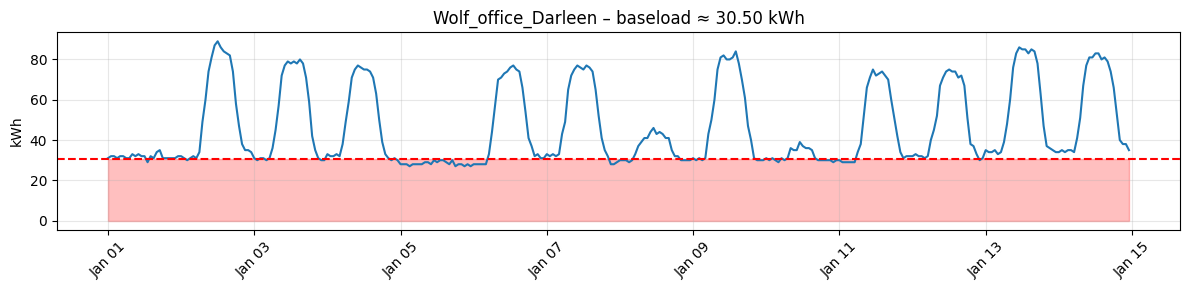

In [21]:
# ------------------------------------------------------------------
# 14‑day plot
# ------------------------------------------------------------------

subset = bldg_hourly.iloc[:24*14]
plt.figure(figsize=(12,3))
plt.plot(subset.index, subset, label='total hourly kWh')
plt.axhline(base_total, color='r', ls='--')
plt.fill_between(subset.index, 0, base_total, color='r', alpha=0.25)
plt.title(f"{bldg} – baseload ≈ {base_total:.2f} kWh")
plt.ylabel('kWh')
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Geospatial Visualization    

In [22]:
loc_info = pd.read_csv("data/metadata/metadata.csv")
loc_info = loc_info[["building_id", "lat", "lng"]]

loc_complete = pd.merge(df_interpolated, loc_info, on="building_id", how="left")

In [23]:
loc_complete.head()

,timestamp_local,building_id,meter_reading,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature,lat,lng
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.85,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 08:00:00,4.4,37.871903,-122.260729
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.25,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 09:00:00,4.4,37.871903,-122.260729
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.50,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 10:00:00,4.4,37.871903,-122.260729
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.40,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 11:00:00,4.4,37.871903,-122.260729
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.25,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 12:00:00,5.0,37.871903,-122.260729


In [28]:
# Create a GeoDataFrame from your building data
def create_building_gdf(building_df):
    # Create geometry column from lat/long
    geometry = [Point(xy) for xy in zip(building_df['lng'], building_df['lat'])]
    gdf = gpd.GeoDataFrame(building_df, geometry=geometry)
    
    # Set coordinate reference system (CRS)
    gdf.crs = "EPSG:4326"  # WGS84 - standard for GPS coordinates
    return gdf

In [29]:
# Replace the existing code (cell with ID "5d6495dd") with this enhanced version:

# --- Enhanced Energy Metrics ---
# First ensure timestamp_local is datetime
df_interpolated['timestamp_local'] = pd.to_datetime(df_interpolated['timestamp_local'])

# Add time-based flags
df_interpolated['hour'] = df_interpolated['timestamp_local'].dt.hour
# Add day_of_week extraction here
df_interpolated['day_of_week'] = df_interpolated['timestamp_local'].dt.dayofweek  # 0=Monday, 6=Sunday
df_interpolated['is_weekend'] = df_interpolated['day_of_week'].isin([5, 6]).astype(int)
df_interpolated['is_working_hours'] = (df_interpolated['hour'].between(9, 17)) & (~df_interpolated['is_weekend'])

# Monthly averages
monthly_avg = df_interpolated.groupby(['building_id', pd.Grouper(key='timestamp_local', freq='M')])['meter_reading'].mean().reset_index()

# Working hours vs. non-working hours
worktime_avg = df_interpolated.groupby(['building_id', 'is_working_hours'])['meter_reading'].mean().reset_index()
worktime_pivot = worktime_avg.pivot(index='building_id', columns='is_working_hours', values='meter_reading').reset_index()
worktime_pivot.columns = ['building_id', 'non_working_hours_avg', 'working_hours_avg']

# Create seasonal averages
seasonal_energy = df_interpolated.copy()
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Apply the function to get seasons
seasonal_energy['season'] = seasonal_energy['timestamp_local'].dt.month.apply(get_season)
seasonal_avg = seasonal_energy.groupby(['building_id', 'season'])['meter_reading'].mean().reset_index()
seasonal_pivot = seasonal_avg.pivot(index='building_id', columns='season', values='meter_reading').reset_index()

# --- Create GeoDataFrame ---
# Create the GeoDataFrame
building_gdf = create_building_gdf(loc_complete)

# Join with your basic energy data (keep simple average for comparison)
building_energy = building_gdf.merge(
    df_interpolated.groupby('building_id')['meter_reading'].mean().reset_index(),
    on='building_id'
)

# Add working hours comparison
building_energy = building_energy.merge(worktime_pivot, on='building_id', how='left')

# Add seasonal data
building_energy = building_energy.merge(seasonal_pivot, on='building_id', how='left')

# Calculate working/non-working ratio
building_energy['work_nonwork_ratio'] = building_energy['working_hours_avg'] / building_energy['non_working_hours_avg']

In [30]:
building_energy.head()

,timestamp_local,building_id,meter_reading_x,timezone,site_id,primaryspaceusage,sqm,timestamp_utc,airTemperature,lat,lng,geometry,meter_reading_y,non_working_hours_avg,working_hours_avg,Fall,Spring,Summer,Winter,work_nonwork_ratio
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.85,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 08:00:00,4.4,37.871903,-122.260729,POINT (-122.26073 37.8719),493.689969,442.770414,632.896941,512.948114,479.047133,432.054057,527.678661,1.429402
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.25,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 09:00:00,4.4,37.871903,-122.260729,POINT (-122.26073 37.8719),493.689969,442.770414,632.896941,512.948114,479.047133,432.054057,527.678661,1.429402
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.50,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 10:00:00,4.4,37.871903,-122.260729,POINT (-122.26073 37.8719),493.689969,442.770414,632.896941,512.948114,479.047133,432.054057,527.678661,1.429402
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.40,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 11:00:00,4.4,37.871903,-122.260729,POINT (-122.26073 37.8719),493.689969,442.770414,632.896941,512.948114,479.047133,432.054057,527.678661,1.429402
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.25,US/Pacific,Bear,Entertainment/public assembly,22117.0,2016-01-01 12:00:00,5.0,37.871903,-122.260729,POINT (-122.26073 37.8719),493.689969,442.770414,632.896941,512.948114,479.047133,432.054057,527.678661,1.429402


In [40]:
# Identify buildings with missing lat/lng values
buildings_with_missing_coords = building_energy[
    building_energy['lat'].isna() | building_energy['lng'].isna()
]['building_id'].unique()

print(f"Found {len(buildings_with_missing_coords)} buildings with missing coordinates")
print(buildings_with_missing_coords[:10])  # Show first few for inspection

Found 232 buildings with missing coordinates
['Bobcat_assembly_Adam' 'Bobcat_assembly_Billy' 'Bobcat_assembly_Camilla'
 'Bobcat_assembly_Franklin' 'Bobcat_education_Alissa'
 'Bobcat_education_Angela' 'Bobcat_education_Barbra'
 'Bobcat_education_Coleman' 'Bobcat_education_Dylan'
 'Bobcat_education_Emile']


Interactive Map with Folium

In [49]:
# Fix the building_energy DataFrame to have just one row per building
print("Current data shape:", building_energy.shape)
print("Number of unique buildings:", building_energy['building_id'].nunique())

# Create a dataset with just one row per building
building_summary = building_energy.drop_duplicates(subset=['building_id'])

# Filter out buildings with missing coordinates or key metrics
building_summary = building_summary[
    building_summary['lat'].notna() & 
    building_summary['lng'].notna() & 
    building_summary['meter_reading_y'].notna()
]
print("Building summary shape (after removing NaNs):", building_summary.shape)

# Calculate center point for initial view
center_lat = building_summary['lat'].mean()
center_lon = building_summary['lng'].mean()

# Create base map
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

# Create a MarkerCluster for better performance
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster(name="All Buildings").add_to(m)

# Pre-calculate all color thresholds
print("Pre-calculating color thresholds...")
color_thresholds = {
    'meter_reading_y': {
        'q25': building_summary['meter_reading_y'].quantile(0.25),
        'q50': building_summary['meter_reading_y'].quantile(0.50),
        'q75': building_summary['meter_reading_y'].quantile(0.75)
    }
}

for season in ["Winter", "Spring", "Summer", "Fall"]:
    color_thresholds[season] = {
        'q25': building_summary[season].dropna().quantile(0.25),
        'q50': building_summary[season].dropna().quantile(0.50),
        'q75': building_summary[season].dropna().quantile(0.75)
    }

# Helper function to determine colors based on thresholds
def get_color(value, thresholds):
    if pd.isna(value):
        return 'gray'  # Default color for missing values
    if value <= thresholds['q25']:
        return 'green'
    elif value <= thresholds['q50']:
        return 'yellow'
    elif value <= thresholds['q75']:
        return 'orange'
    else:
        return 'red'

# Progress tracking functions (no changes)
def track_progress(iterable, total=None, desc="Processing"):
    if total is None:
        total = len(iterable)
    
    print(f"{desc} (0/{total})... ", end="", flush=True)
    
    for i, item in enumerate(iterable):
        if (i+1) % max(1, total // 10) == 0:  # Print update every 10%
            print(f"{(i+1)}/{total} ({(i+1)/total*100:.0f}%)... ", end="", flush=True)
        yield item
    
    print("Done!")

# Try to use tqdm if available, otherwise use simple progress tracker
try:
    from tqdm import tqdm
    progress_tracker = lambda it, **kwargs: tqdm(it, **kwargs)
except:
    progress_tracker = track_progress

# Add buildings to map with progress tracking
print(f"Creating map for {len(building_summary)} buildings...")
try:
    progress_iter = progress_tracker(
        building_summary.iterrows(),
        total=len(building_summary),
        desc="Adding buildings to map"
    )
except:
    progress_iter = track_progress(
        building_summary.iterrows(),
        total=len(building_summary), 
        desc="Adding buildings to map"
    )

for idx, row in progress_iter:
    try:
        # Using try-except to handle any unexpected formatting issues
        
        # Safely handle values with defaults for NaN
        working_hours_avg = row['working_hours_avg'] if pd.notna(row['working_hours_avg']) else 0
        non_working_hours_avg = row['non_working_hours_avg'] if pd.notna(row['non_working_hours_avg']) else 0
        work_nonwork_ratio = row['work_nonwork_ratio'] if pd.notna(row['work_nonwork_ratio']) else 0
        winter = row['Winter'] if pd.notna(row['Winter']) else 0
        spring = row['Spring'] if pd.notna(row['Spring']) else 0
        summer = row['Summer'] if pd.notna(row['Summer']) else 0
        fall = row['Fall'] if pd.notna(row['Fall']) else 0
        
        # Create popup content with expandable sections for better performance
        popup_html = f"""
            <h4>Building ID: {row['building_id']}</h4>
            <b>Primary Usage:</b> {row.get('primaryspaceusage', 'N/A')}<br>
            <b>Size:</b> {row.get('sqm', 'N/A')} sqm<br>
            <hr>
            <details>
                <summary><b>Average Energy:</b> {row['meter_reading_y']:.1f} kWh</summary>
                <p><b>Working hours avg:</b> {working_hours_avg:.1f} kWh</p>
                <p><b>Non-working hours avg:</b> {non_working_hours_avg:.1f} kWh</p>
                <p><b>Work/Non-work ratio:</b> {work_nonwork_ratio:.2f}</p>
            </details>
            <details>
                <summary><b>Seasonal Data</b></summary>
                <p><b>Winter:</b> {winter:.1f} kWh</p>
                <p><b>Spring:</b> {spring:.1f} kWh</p>
                <p><b>Summer:</b> {summer:.1f} kWh</p>
                <p><b>Fall:</b> {fall:.1f} kWh</p>
                <p><b>Winter/Summer ratio:</b> {winter/summer if summer > 0 else 0:.2f}</p>
            </details>
        """
        
        popup = folium.Popup(popup_html, max_width=300)
        
        # Add to cluster group - just ONE marker per building
        radius = max(5, min(15, row['sqm']/500)) if 'sqm' in row.index and pd.notna(row['sqm']) else 8
        
        # Determine color based on energy intensity
        color = get_color(row['meter_reading_y'], color_thresholds['meter_reading_y'])
        
        # Create marker
        folium.CircleMarker(
            location=[row['lat'], row['lng']],
            radius=radius,
            popup=popup,
            tooltip=f"Building: {row['building_id']} ({row['meter_reading_y']:.1f} kWh)",
            color=color,
            fill=True,
            fill_opacity=0.7
        ).add_to(marker_cluster)
    except Exception as e:
        print(f"Error processing building {row['building_id']}: {e}")

# Add seasonal heatmaps (more efficient than marker layers)
print("Creating seasonal heatmaps...")
heatmap_groups = {}

for season in ["Winter", "Summer"]:
    heatmap_data = [[row['lat'], row['lng'], row[season]] 
                   for _, row in building_summary.iterrows() 
                   if pd.notna(row[season]) and pd.notna(row['lat']) and pd.notna(row['lng'])]
    
    heatmap_groups[season] = folium.plugins.HeatMap(
        heatmap_data, 
        name=f"{season} Energy Use", 
        min_opacity=0.3,
        radius=15,
        blur=10
    ).add_to(m)

# Add Winter-Summer difference heatmap
winter_summer_diff = []
for _, row in building_summary.iterrows():
    if pd.notna(row['Winter']) and pd.notna(row['Summer']) and pd.notna(row['lat']) and pd.notna(row['lng']):
        winter_summer_diff.append([row['lat'], row['lng'], row['Winter'] - row['Summer']])

folium.plugins.HeatMap(winter_summer_diff, 
                      name="Winter-Summer Difference", 
                      min_opacity=0.3,
                      radius=15,
                      blur=10).add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Add a mini legend
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 2px solid grey; border-radius: 5px;">
<h4>Legend</h4>
<p><i class="fa fa-circle" style="color:green"></i> Low (0-25%)</p>
<p><i class="fa fa-circle" style="color:yellow"></i> Medium-Low (25-50%)</p>
<p><i class="fa fa-circle" style="color:orange"></i> Medium-High (50-75%)</p>
<p><i class="fa fa-circle" style="color:red"></i> High (75-100%)</p>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map
print("Saving map to HTML file...")
m.save('building_energy_interactive_map.html')
print("Map saved successfully!")

Current data shape: (25559768, 20)
Number of unique buildings: 1572
Building summary shape (after removing NaNs): (1340, 20)
Pre-calculating color thresholds...
Creating map for 1340 buildings...


Adding buildings to map: 100%|██████████| 1340/1340 [00:15<00:00, 85.77it/s] 


Creating seasonal heatmaps...
Saving map to HTML file...
Map saved successfully!
